# Evaluation Metrics
The metrics we will use are:

**1. Style Transfer Intensity (STI)**

The STI metric is used to measure how much a
style transfer model has changed the style of a text sample.

**2. Content Preservation Score (CPS)**

The CPS metric is used to measure how well a
style transfer model preserves the original content of a text sample.


In [19]:
import pandas as pd
from scipy.stats import wasserstein_distance
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import numpy as np

In [20]:
# Load the CSV file
file_path = '../data/data_for_eval.csv'
df = pd.read_csv(file_path)

# Ensure the column names match CSV file's column names
source_label_0_col = 'source_label_0'
source_label_1_col = 'source_label_1'
target_label_0_col = 'target_label_0'
target_label_1_col = 'target_label_1'
predicted_label_0_col = 'predicted_label_0'  
predicted_label_1_col = 'predicted_label_1'

## For Style Transfer Intensity (STI) calculation using Earth Mover's Distance
1. EMD Calculation

EMD is calculated between the style distributions (probabilities) of the source text and the predicted text, as well as between the target text and the predicted text.

2. Style Distributions

The style distribution for each text type (source, target, predicted) is represented by the probabilities that the text is neutral or subjective. These are stored in the columns like source_label_0, source_label_1, etc.

3. EMD for Source-Predicted

For each pair of source and predicted texts, EMD measures how much the style of the text has shifted after the style transfer. A lower EMD indicates a smaller shift, suggesting that the predicted text retains much of the source text's style.

4. EMD for Target-Predicted

Similarly, EMD between the target and predicted texts measures how close the style of the predicted text is to the desired target style. A lower EMD here indicates that the predicted text closely matches the target style.

In [33]:
# Calculate EMD for Style Transfer Intensity (STI)

# Here, 'source_label_0' and 'source_label_1' are the probabilities for the source text being neutral and subjective, respectively
# Similarly for 'target_label_0', 'target_label_1', 'predicted_label_0', and 'predicted_label_1'

emd_source_predicted = [wasserstein_distance([row[source_label_0_col], row[source_label_1_col]],
                                              [row[predicted_label_0_col], row[predicted_label_1_col]])
                        for index, row in df.iterrows()]
emd_target_predicted = [wasserstein_distance([row[target_label_0_col], row[target_label_1_col]],
                                              [row[predicted_label_0_col], row[predicted_label_1_col]])
                        for index, row in df.iterrows()]
emd_source_target = [wasserstein_distance([row[target_label_0_col], row[target_label_1_col]],
                                              [row[source_label_0_col], row[source_label_1_col]])
                        for index, row in df.iterrows()]

In [21]:

# Calculate Content Preservation Score
model = SentenceTransformer('bert-base-nli-mean-tokens')
source_embeddings = model.encode(df['source_text'].tolist())
predicted_embeddings = model.encode(df['predictions'].tolist())

## For Content Preservation Score (CPS) calculation

**1. Compute Sentence Embeddings**

SentenceTransformer Model: The code uses a pre-trained model from the sentence-transformers library, specifically 'bert-base-nli-mean-tokens'. This model is designed to produce meaningful sentence embeddings for a wide range of texts.

Embeddings for Source and Predicted Texts: The model encodes both the source and predicted texts, converting them into high-dimensional vectors (embeddings) that represent their semantic content.

**2. Calculate Cosine Similarity for Content Preservation**

Cosine Similarity: This metric measures the cosine of the angle between two vectors. In the context of sentence embeddings, a higher cosine similarity indicates greater semantic similarity between texts.

Iterative Comparison: The code iterates over each pair of source and predicted embeddings, calculating the cosine similarity for each pair. This value ranges from -1 to 1, where 1 means identical directionality (high semantic similarity), 0 indicates orthogonality (no similarity), and -1 implies completely opposite directionality.

In [22]:
content_scores = [1 - cosine(source_emb, pred_emb) 
                  if not np.isnan(cosine(source_emb, pred_emb)) else 0
                  for source_emb, pred_emb in zip(source_embeddings, predicted_embeddings)]

In [34]:
# Combine results in a new DataFrame
evaluation_df = pd.DataFrame({
    "Source Text": df['source_text'],
    "Target Text": df['target_text'],
    "Predicted Text": df['predictions'],
    "EMD Source-Predicted": emd_source_predicted,
    "EMD Target-Predicted": emd_target_predicted,
	"EMD Source-Target": emd_source_target,
    "Content Preservation Score": content_scores
})

In [35]:
print(evaluation_df.head())

                                         Source Text  \
0  in april 2009 a brazilian human rights group, ...   
1  the 51 day standoff and ensuing murder of 76 m...   
2  mark oaten (born 8 march 1964, watford) is a d...   
3  another infamous period of colonisation in anc...   
4  photo sequence of astonishing 2005 chicagoland...   

                                         Target Text  \
0  in april 2009 a brazilian human rights group, ...   
1  the 51 day standoff and ensuing deaths of 76 m...   
2  mark oaten (born 8 march 1964, watford) is a l...   
3  another period of colonisation in ancient time...   
4  photo sequence of 2005 chicagoland crash with ...   

                                      Predicted Text  EMD Source-Predicted  \
0  in april 2009 a brazilian human rights group, ...              0.000000   
1  the 51 day standoff and ensuing murder of 76 m...              0.000000   
2  mark oaten (born 8 march 1964, watford) is a l...              0.037568   
3  another per

In [7]:
# # Save the evaluation DataFrame to a new CSV file
# evaluation_csv_path = "../../data/evaluated.csv"
# evaluation_df.to_csv(evaluation_csv_path, index=False)

# print("Evaluation data saved to:", evaluation_csv_path)

Evaluation data saved to: ../../data/evaluated.csv


In [27]:
evaluation_df.iloc[2]

Source Text                   mark oaten (born 8 march 1964, watford) is a d...
Target Text                   mark oaten (born 8 march 1964, watford) is a l...
Predicted Text                mark oaten (born 8 march 1964, watford) is a l...
EMD Source-Predicted                                                   0.037568
EMD Target-Predicted                                                        0.0
Content Preservation Score                                              0.93439
Name: 2, dtype: object

We Need to combine the SWD metrics into a single STI. 

This statement has been successfully neutralized by the model (EMD Target-Predicted = 0). However, CPS shows value 0.93. This is due to the blant cosine similarity matching between source and oredicted text. The style transferred word is reducing the CPS score.
Thereofre we need to remove that Word to make CPS more appropriate

Therefore we will refine evaluation metrics

# Refined Evaluation metrics

In [15]:
# df_renamed = df.rename(columns={"source_text":"source_text","source_label_0":"source_prob_S","source_label_1":"source_prob_N","target_text":"target_text",
# 		   "target_label_0":"target_prob_S","target_label_1":"taget_prob_N","predictions":"predictions","predicted_label_0":"predicted_prob_S","predicted_label_1":"predicted_label_N"})

# # Ensure the column names match CSV file's column names
# source_label_0_col = 'source_label_0'
# source_label_1_col = 'source_label_1'
# target_label_0_col = 'target_label_0'
# target_label_1_col = 'target_label_1'
# predicted_label_0_col = 'predicted_label_0'  
# predicted_label_1_col = 'predicted_label_1'

### calculating directional STI

In [36]:
evaluation_df.head()

,Source Text,Target Text,Predicted Text,EMD Source-Predicted,EMD Target-Predicted,EMD Source-Target,Content Preservation Score
0,"in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...","in april 2009 a brazilian human rights group, ...",0.000000,0.097619,0.097619,1.000000
1,the 51 day standoff and ensuing murder of 76 m...,the 51 day standoff and ensuing deaths of 76 m...,the 51 day standoff and ensuing murder of 76 m...,0.000000,0.148595,0.148595,1.000000
2,"mark oaten (born 8 march 1964, watford) is a d...","mark oaten (born 8 march 1964, watford) is a l...","mark oaten (born 8 march 1964, watford) is a l...",0.037568,0.000000,0.037568,0.934390
3,another infamous period of colonisation in anc...,another period of colonisation in ancient time...,another period of colonisation in ancient time...,0.025609,0.000000,0.025609,0.851425
4,photo sequence of astonishing 2005 chicagoland...,photo sequence of 2005 chicagoland crash with ...,photo sequence of 2005 chicagoland crash with ...,0.001016,0.000000,0.001016,0.983531


Logic : If emd between source and predicted is lesser than the emd between target and predicted, then it is gievn negative sign

In [84]:
#Defining intuitive STI  : more 'accurate' style transfer is when prediction is close to target + far away from source.
# 1. more intuitive
# 2. Focuses on genuine style transfers
# 2. penalizes no change in source, target and prediction
evaluation_df['STI'] = evaluation_df['EMD Source-Predicted'] + (1/(1+evaluation_df['EMD Target-Predicted']))
evaluation_df['STI'] = evaluation_df['STI'] - evaluation_df['STI'].min()

In [85]:
import matplotlib.pyplot as plt 
import seaborn as sns

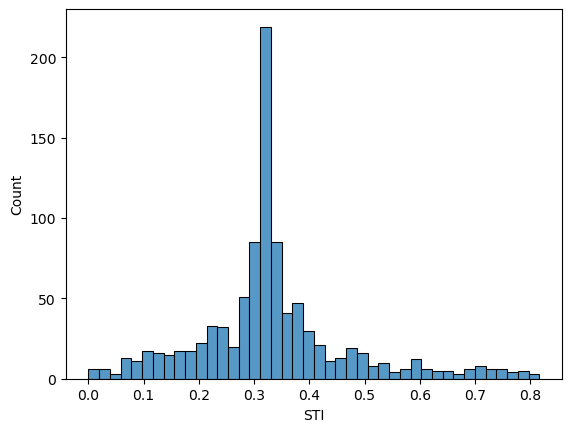

In [86]:
sns.histplot(evaluation_df,x='STI')
plt.show()

Most texts have STI of 0.32

In [87]:
#Let us check some examples with high STI
max_sti_df = evaluation_df.sort_values(by='STI',ascending=False).head(n = 5) 

In [88]:
print("source text :" ,max_sti_df['Source Text'].iloc[0])
print("Target Text : ", max_sti_df['Target Text'].iloc[0])
print("Predicted Text : ", max_sti_df['Predicted Text'].iloc[0])


source text : muzaffarabad is the capital of the pakistani territory of pakistan occupied kashmir.
Target Text :  muzaffarabad is the capital of the pakistani territory of pakistan administered kashmir.
Predicted Text :  muzaffarabad is the capital of the pakistani territory of pakistan administered kashmir.


Perfect Style Transfer

In [89]:
print("source text :" ,max_sti_df['Source Text'].iloc[1])
print("Target Text : ", max_sti_df['Target Text'].iloc[1])
print("Predicted Text : ", max_sti_df['Predicted Text'].iloc[1])


source text : it also has a small concessions stand, run by the fantastic volunteer staff, which sells refreshments and earplugs.
Target Text :  it also has a small concessions stand, run by the volunteer staff, which sells refreshments and earplugs.
Predicted Text :  it also has a small concessions stand, run by the volunteer staff, which sells refreshments and earplugs.


In [90]:
print("source text :" ,max_sti_df['Source Text'].iloc[3])
print("Target Text : ", max_sti_df['Target Text'].iloc[3])
print("Predicted Text : ", max_sti_df['Predicted Text'].iloc[3])

source text : he is best known for his metal wall sculptures and looney tunes shadow boxes.
Target Text :  he is known for his metal wall sculptures and looney tunes shadow boxes.
Predicted Text :  he is known for his metal wall sculptures and looney tunes shadow boxes.


High STI is when prediction text style matches perfecty with Target Text Style

#Let us look at most common STI examples. (STI = 0.32)

In [112]:
common_sti_df = evaluation_df[(evaluation_df['STI']>=0.3) & (evaluation_df['STI'] < 0.33)]

In [99]:
#Let us check some examples
common_sti_df = common_sti_df.sort_values(by='STI',ascending=False)

In [100]:
print("source text :" ,common_sti_df['Source Text'].iloc[3])
print("Target Text : ", common_sti_df['Target Text'].iloc[3])
print("Predicted Text : ", common_sti_df['Predicted Text'].iloc[3])

source text : kulhawik received her bachelor of arts degree in english & secondary education from simmons college in 1974. one of the top two graduating seniors at simmons, kulhawik received the prestigious crown zellerbach award and a full fellowship from the university of vermont, where she received a double master's degree in english/education in 1977. she taught english at brookline high school from 1976 through 1978, and at the boston architectural center from 1977 through 1979.
Target Text :  kulhawik received her bachelor of arts degree in english & secondary education from simmons college in 1974. one of the top two graduating seniors at simmons, kulhawik received the crown zellerbach award and a full fellowship from the university of vermont, where she received a double master's degree in english/education in 1977. she taught english at brookline high school from 1976 through 1978, and at the boston architectural center from 1977 through 1979.
Predicted Text :  kulhawik receiv

In [101]:
print("source text :" ,common_sti_df['Source Text'].iloc[10])
print("Target Text : ", common_sti_df['Target Text'].iloc[10])
print("Predicted Text : ", common_sti_df['Predicted Text'].iloc[10])

source text : in recent years, the term has often been misapplied to those who are merely clean-cut.
Target Text :  in recent years, the term has often been applied to those who are merely clean-cut.
Predicted Text :  in recent years, the term has often been used to describe those who are merely clean-cut.


Minimum STI

In [111]:
min_sti_df = evaluation_df[(evaluation_df['STI']>=0) & (evaluation_df['STI'] < 0.2)]

In [113]:
print("source text :" ,min_sti_df['Source Text'].iloc[15])
print("Target Text : ", min_sti_df['Target Text'].iloc[15])
print("Predicted Text : ", min_sti_df['Predicted Text'].iloc[15])

source text : aiming at palestinian qassam rockets and grad launchers in an open area, seven of the shells landed 1 km off target and hit houses in the outskirts of beit hanoun.
Target Text :  although israel claimed they aimed at palestinian qassam rockets and grad launchers in an open area, seven of the shells landed 1 km off target and hit houses in the outskirts of beit hanoun.
Predicted Text :  aiming at palestinian qassam rockets and grad launchers in an open area, seven of the shells landed 1 km off target and hit houses in the outskirts of beit hanoun.


No change in prediction 

### CPS

In [116]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers_interpret import SequenceClassificationExplainer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CLS_MODEL_PATH)

In [117]:
test = 'Harvard is a beautiful school'

In [ ]:
cls_explainer = SequenceClassificationExplainer(model, tokenizer)
word_attributions = cls_explainer(test)

In [ ]:
# Create a DataFrame
df_attrb = pd.DataFrame(word_attributions, columns=['token', 'score'])
df_attrb.sort_values(by='score')
# Calculate the cumulative score
df_attrb['cum_score'] = df_attrb['score'].cumsum()

threshold_score = 0.5
# Filter tokens with score less than threshold
df_attrb_filtered = df_attrb[df_attrb['cum_score'] <= threshold_score]


In [ ]:
# Create a DataFrame
df_attrb = pd.DataFrame(word_attributions, columns=['token', 'score'])
df_attrb.sort_values(by='score')
# Calculate the cumulative score
df_attrb['cum_score'] = df_attrb['score'].cumsum()

threshold_score = 0.5
# Filter tokens with score less than threshold
df_attrb_filtered = df_attrb[df_attrb['cum_score'] <= threshold_score]
